In [1]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import glob
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings


warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code

# session lists in a .py file
# import sessionlists
%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/test.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/sequencesALLDATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /Users/tom/Desktop/sequencesALLDATA
Current working directory: /Users/tom/test1/code
Save Path:  /Users/tom/Desktop/Save
Found 19 rats in the data folder


In [3]:
rat_markers = {}
params = {}
nb_runsBin = {}
speedRunToLeftBin, speedRunToRightBin = {}, {}
timeRunToLeftBin, timeRunToRightBin = {}, {}
maxSpeedLeftBin, maxSpeedRightBin = {}, {}
timeStayInLeftBin, timeStayInRightBin = {}, {}
totalDistance, totalWater, total_trials = {}, {}, {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
sequence = {}

# # define colors for each rat
# palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2),
#            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2),
#            'RatF20': (0.4, 0.0, 0.0), 'RatF21': (0.55, 0.13, 0.13), 'RatF22': (0.8, 0.2, 0.2),
#            'RatM20': (0.0, 0.4, 0.0), 'RatM21': (0.13, 0.55, 0.13), 'RatM22': (0.2, 0.8, 0.2),
#            'RatF30': (0.4, 0.0, 0.0), 'RatF31': (0.55, 0.13, 0.13), 'RatF32': (0.8, 0.2, 0.2), 'RatF33': (0.8, 0.2, 0.2),
#            'RatM30': (0.0, 0.4, 0.0), 'RatM31': (0.13, 0.55, 0.13), 'RatM32': (0.2, 0.8, 0.2), 
#            'RatF30L': (0.4, 0.0, 0.0), 'RatF31L': (0.55, 0.13, 0.13), 'RatF32L': (0.8, 0.2, 0.2), 'RatF33L': (0.8, 0.2, 0.2),
#            'RatM30L': (0.0, 0.4, 0.0), 'RatM31L': (0.13, 0.55, 0.13), 'RatM32L': (0.2, 0.8, 0.2)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal'}

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}

# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32']

F, M = 0, 0
nF, nM = len(fnmatch.filter(animalList, 'RatF*')), len(fnmatch.filter(animalList, 'RatM*'))

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[plt.cm.get_cmap('Reds')(F/nF), 'd', lines[brainstatus[animal]]]
        F += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[plt.cm.get_cmap('Greens')(M/nM), 's', lines[brainstatus[animal]]]
        M += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
                                                #  dist60bis+dist90bis+dist120bis)):

        # get the preprocessed data from the pickle file
        # In this notebook we only need the sequence of events, so we only load that
        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32


In [4]:
# separate the data into time and reward bins for each experimental condition
# distances 
data60IDLE = prepare_data_idle_times(sequence, animalList, dist60)
data90IDLE = prepare_data_idle_times(sequence, animalList, dist90)
data120IDLE = prepare_data_idle_times(sequence, animalList, dist120)

data60RUN = prepare_data_running_times(sequence, animalList, dist60)
data90RUN = prepare_data_running_times(sequence, animalList, dist90)
data120RUN = prepare_data_running_times(sequence, animalList, dist120)

# treadmill speeds
data20IDLE = prepare_data_idle_times(sequence, animalList, TM20)
data10IDLE = prepare_data_idle_times(sequence, animalList, TM10)
data2IDLE = prepare_data_idle_times(sequence, animalList, TM2+TMrev2)
datarev10IDLE = prepare_data_idle_times(sequence, animalList, TMrev10)
datarev20IDLE = prepare_data_idle_times(sequence, animalList, TMrev20)

data20RUN = prepare_data_running_times(sequence, animalList, TM20)
data10RUN = prepare_data_running_times(sequence, animalList, TM10)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20)

# all conditions pooled
dataAllIDLE = prepare_data_idle_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)
dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)


In [5]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32']
# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R,], open("picklejar/intact_lesionFITS.p", "wb"))
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32']

# animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
#             'RatF32', 'RatF33', 'RatM31', 'RatM32', 
#             'RatF42', 'RatM40', 'RatM43']
# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R,], open("picklejar/intactFITS.p", "wb"))
# alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intactFITS.p", "rb"))

$\alpha_0$: 0.059
$\alpha_t$: 0.003
$\alpha_R$: 0.045
$\gamma_0$: 0.773
$\gamma_t$: 0.031
$\gamma_R$: 0.471
$\mu_0$: 0.0064
$\mu_t$: 0.1793
$\mu_R$: 0.0253
$\sigma_0$: 0.0873
$\sigma_t$: 0.758
$\sigma_R$: 0.055


(-6.0, 6.0)

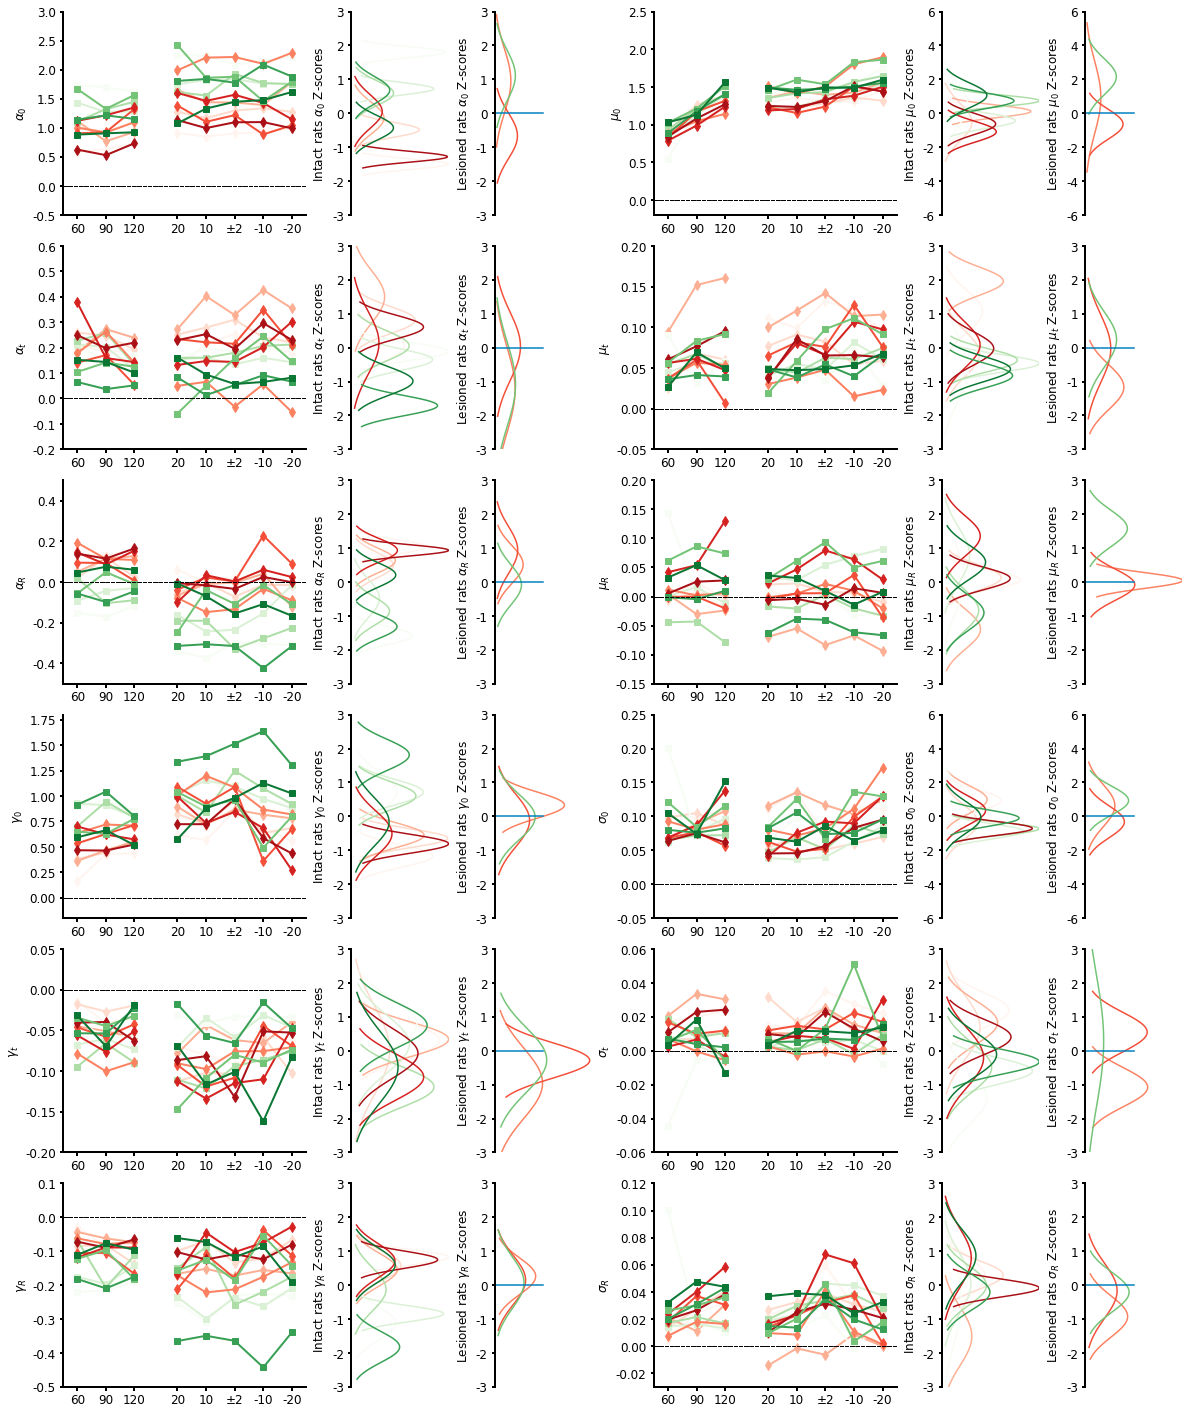

In [6]:
fig, axs = plt.subplots(6, 6, figsize=(42/2.56, 50/2.56), gridspec_kw={'width_ratios': [5, 2, 2, 5, 2, 2]}, constrained_layout=True)
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.2, .6], [-.5, .5], [-.2, 1.8], [-.2, .05], [-.5, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .2], [-.05, .25], [-.06, .06], [-.03, .12], ]

varsIDLE = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
varsRUN = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 8)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 3].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].set_title(f"")
        axs[i, 3].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 3].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 3].set_ylabel(ylabel)
        axs[i, 3].set_xlim(-.5, 8)
        axs[i, 3].set_ylim(ylim)
        axs[i, 3].axhline(0, color='black', linestyle='--', linewidth=1)
    


Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}

traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsIDLE[animal].append(np.mean(zscores))
        if brainstatus[animal] == "normal":
            axs[j, 1].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 2].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print(f"{ylabelsIDLE[j]}: {perm:.3f}")

    # axs[j, 1].set_ylim(xmin, xmax)
    axs[j, 1].set_ylim(-3, 3)
    axs[j, 1].set_xlim(0, ymax)
    axs[j, 1].set_ylabel(f"Intact rats {ylabelsIDLE[j]} Z-scores")
    axs[j, 1].set_xlabel("")
    axs[j, 1].set_xticks([])
    axs[j, 1].spines['bottom'].set_visible(False)
    axs[j, 2].set_ylim(xmin, xmax)
    axs[j, 2].plot([0, ymax/2], [0, 0], c=plt.cm.get_cmap('winter')(.5))
    axs[j, 2].set_ylim(-3, 3)
    axs[j, 2].set_xlim(0, ymax)
    axs[j, 2].set_ylabel(f"Lesioned rats {ylabelsIDLE[j]} Z-scores")
    axs[j, 2].set_xlabel("")
    axs[j, 2].set_xticks([])
    axs[j, 2].spines['bottom'].set_visible(False)



Zmu = {animal: {key: (mu[animal][key] - np.mean([mu[animal][key] for animal in intact]))/np.std([mu[animal][key] for animal in intact]) for key in mu[animal]} for animal in animalList}
Zmu_t = {animal: {key: (mu_t[animal][key] - np.mean([mu_t[animal][key] for animal in intact]))/np.std([mu_t[animal][key] for animal in intact]) for key in mu_t[animal]} for animal in animalList}
Zmu_R = {animal: {key: (mu_R[animal][key] - np.mean([mu_R[animal][key] for animal in intact]))/np.std([mu_R[animal][key] for animal in intact]) for key in mu_R[animal]} for animal in animalList}
Zsigma = {animal: {key: (sigma[animal][key] - np.mean([sigma[animal][key] for animal in intact]))/np.std([sigma[animal][key] for animal in intact]) for key in sigma[animal]} for animal in animalList}
Zsigma_t = {animal: {key: (sigma_t[animal][key] - np.mean([sigma_t[animal][key] for animal in intact]))/np.std([sigma_t[animal][key] for animal in intact]) for key in sigma_t[animal]} for animal in animalList}
Zsigma_R = {animal: {key: (sigma_R[animal][key] - np.mean([sigma_R[animal][key] for animal in intact]))/np.std([sigma_R[animal][key] for animal in intact]) for key in sigma_R[animal]} for animal in animalList}

traitsRUN = {animal: [] for animal in animalList}
ZvarsRUN = [Zmu, Zmu_t, Zmu_R, Zsigma, Zsigma_t, Zsigma_R]
for j, zvar in enumerate(ZvarsRUN):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsRUN[animal].append(np.mean(zscores))

        if brainstatus[animal] == "normal":
            axs[j, 4].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 5].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)
    

    allIntact = np.array(allIntact).flatten()
    allLesion = np.array(allLesion).flatten()
    perm = exact_mc_perm_test(allIntact, allLesion)
    print(f"{ylabelsRUN[j]}: {perm}")



    # axs[j, 4].set_ylim(xmin, xmax)
    axs[j, 4].set_ylim(-3, 3)
    axs[j, 4].set_xlim(0, ymax)

    axs[j, 4].set_ylabel(f"Intact rats {ylabelsRUN[j]} Z-scores")
    axs[j, 4].set_xlabel("")
    axs[j, 4].set_xticks([])
    axs[j, 4].spines['bottom'].set_visible(False)
    # axs[j, 5].set_ylim(xmin, xmax)
    axs[j, 5].set_ylim(-3, 3)
    axs[j, 5].set_xlim(0, ymax)
    axs[j, 5].plot([0, ymax/2], [0, 0], c=plt.cm.get_cmap('winter')(.5))
    axs[j, 5].set_ylabel(f"Lesioned rats {ylabelsRUN[j]} Z-scores")
    axs[j, 5].set_xlabel("")
    axs[j, 5].set_xticks([])
    axs[j, 5].spines['bottom'].set_visible(False)


axs[0, 4].set_ylim(-6, 6)
axs[0, 5].set_ylim(-6, 6)

axs[3, 4].set_ylim(-6, 6)
axs[3, 5].set_ylim(-6, 6)

# save_plot_as_png('/media/david/DAA6-6D9D/iBAGS/FitVariaComp.png', dpi=300, transparent=True, background='auto')

$\alpha_0$ corr: 0.49, p: 0.0906
$\alpha_t$ corr: -0.74, p: 0.0040
$\alpha_R$ corr: -0.75, p: 0.0030
$\gamma_0$ corr: 0.78, p: 0.0016
$\gamma_t$ corr: 0.21, p: 0.4935
$\gamma_R$ corr: -0.74, p: 0.0036
$\mu_0$ corr: 0.49, p: 0.0896
$\mu_t$ corr: -0.59, p: 0.0353
$\mu_R$ corr: 0.14, p: 0.6542
$\sigma_0$ corr: -0.33, p: 0.2762
$\sigma_t$ corr: -0.50, p: 0.0787
$\sigma_R$ corr: 0.27, p: 0.3640


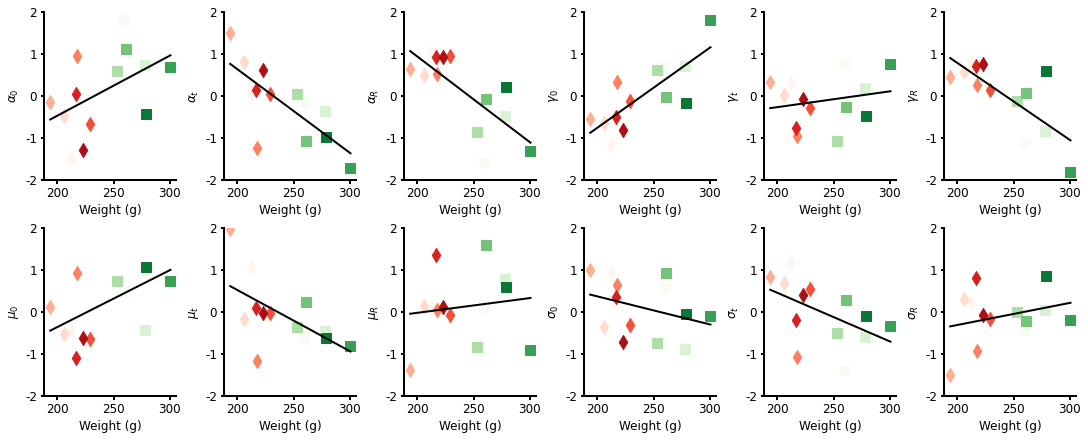

In [7]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for j, zvar in enumerate(ZvarsIDLE):
    _x, _y = [], []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[0, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[0, j].set_xlabel("Weight (g)")
        ax[0, j].set_ylabel(ylabelsIDLE[j])
        ax[0, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsIDLE[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[0, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

for j, zvar in enumerate(ZvarsRUN):
    _x, _y = [], []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[1, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[1, j].set_xlabel("Weight (g)")
        ax[1, j].set_ylabel(ylabelsRUN[j])
        ax[1, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsRUN[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[1, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

$\alpha_0$ corr: 0.52, p: 0.0000
$\alpha_t$ corr: -0.78, p: 0.0000
$\alpha_R$ corr: -0.70, p: 0.0000
$\gamma_0$ corr: 0.74, p: 0.0000
$\gamma_t$ corr: 0.09, p: 0.4516
$\gamma_R$ corr: -0.68, p: 0.0000
$\mu_0$ corr: 0.43, p: 0.0001
$\mu_t$ corr: -0.65, p: 0.0000
$\mu_R$ corr: 0.04, p: 0.7254
$\sigma_0$ corr: -0.28, p: 0.0126
$\sigma_t$ corr: -0.51, p: 0.0000
$\sigma_R$ corr: 0.14, p: 0.2007


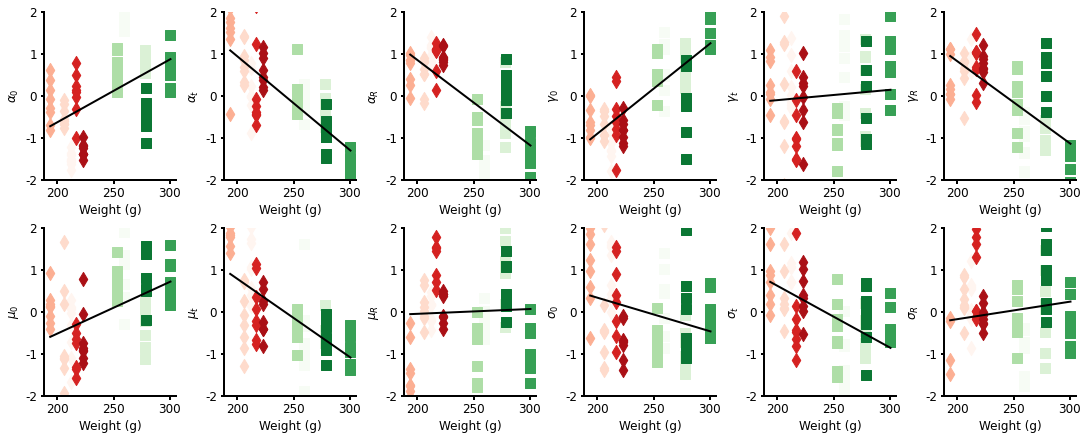

In [8]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for j, zvar in enumerate(ZvarsIDLE):
    _x, _y = [], []
    for animal in intact:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]

        ax[0, j].scatter([weights[animal] for _ in zscores], zscores, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[0, j].set_xlabel("Weight (g)")
        ax[0, j].set_ylabel(ylabelsIDLE[j])
        ax[0, j].set_ylim(-2, 2)

        _x.append([weights[animal] for _ in zscores])
        _y.append(zscores)

    _x = np.array(_x).flatten()
    _y = np.array(_y).flatten()

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsIDLE[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[0, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

for j, zvar in enumerate(ZvarsRUN):
    _x, _y = [], []
    for animal in intact:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]

        ax[1, j].scatter([weights[animal] for _ in zscores], zscores, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[1, j].set_xlabel("Weight (g)")
        ax[1, j].set_ylabel(ylabelsRUN[j])
        ax[1, j].set_ylim(-2, 2)

        _x.append([weights[animal] for _ in zscores])
        _y.append(zscores)

    _x = np.array(_x).flatten()
    _y = np.array(_y).flatten()

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsRUN[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[1, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

In [9]:
# mass in model
# params = a, t, g, a', t', g', a'', t'', g''
def modelwald_fitW(data, init=[2, 0, .5, 0, 0, 0, 0, 0, 0],
                  f=model_crit, N_bins=6, N_avg=4, N_params=2, weight=1, 
                  alpha_t_fixed=False, gamma_t_fixed=False,
                  alpha_R_fixed=False, gamma_R_fixed=False,
                  ):
    """fit full model to data"""
    params_init = np.array(init)
    alpha_t_bounds = (None, None) if not alpha_t_fixed else (0, 1e-8)
    gamma_t_bounds = (None, None) if not gamma_t_fixed else (0, 1e-8)
    alpha_R_bounds = (None, None) if not alpha_R_fixed else (0, 1e-8)
    gamma_R_bounds = (None, None) if not gamma_R_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params, weight),
                   bounds=((0, None), (0, 1e-8), (0, None),
                   alpha_t_bounds, (0, 1e-8), gamma_t_bounds,
                   alpha_R_bounds, (0, 1e-8), gamma_R_bounds))
    return res.x, res.fun


def model_critW(params, *args, robustness_param=1e-20):
    """negative log likelihood function for full model"""
    alpha, theta, gamma, alpha_t, theta_prime, gamma_t, alpha_R, theta_second, gamma_R = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    N_params = args[2]
    weight = args[3]
    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))
    _theta = theta + theta_prime + theta_second

    # alpha /= weight
    # alpha_t /= weight
    # alpha_R /= weight
    # gamma /= weight
    # gamma_t /= weight
    # gamma_R /= weight

    alpha *= weight
    alpha_t *= weight
    alpha_R *= weight
    gamma *= weight
    gamma_t *= weight
    gamma_R *= weight

    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = alpha + bin*alpha_t + avg*alpha_R
            GAMMA[bin, avg] = gamma + bin*gamma_t + avg*gamma_R

    for bin in range(N_bins):
        for avg in range(N_avg):
            _alpha = ALPHA[bin, avg] if ALPHA[bin, avg] > 0 else 1e-8
            _gamma = GAMMA[bin, avg]# if GAMMA[bin, avg] > 0 else 1e-8
            try:
                pdf_vals = Wald_pdf(args[0][bin][avg], _alpha, _theta, _gamma)
                ln_pdf_vals = np.log(pdf_vals + robustness_param)
                log_lik_val = ln_pdf_vals.sum()

                n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
                neg_log_lik_val += (-log_lik_val / n)
            except:
                neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val


def oh_wow(*args):
    global beurk
    beurk = {}
    l = 0
    init = args[0]
    data = args[1]
    for animal in animalList:
        res = modelwald_fitW(data[animal], f=model_critW, weight=weights[animal]/1000)
        l += res[1]
        beurk[animal] = res[0]
        # print(animal, res)
    # print(l)
    return l

# test = minimize(oh_wow, [1.5, 0, .75, 0.2, 0, -0.07, 0, 0, -0.2], args=(data60IDLE))

In [10]:
for animal in animalList: 
    cond="60"
    (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]) = beurk[animal]

NameError: name 'beurk' is not defined

60
90
120


Text(0.5, 0, '$v_{belt}$')

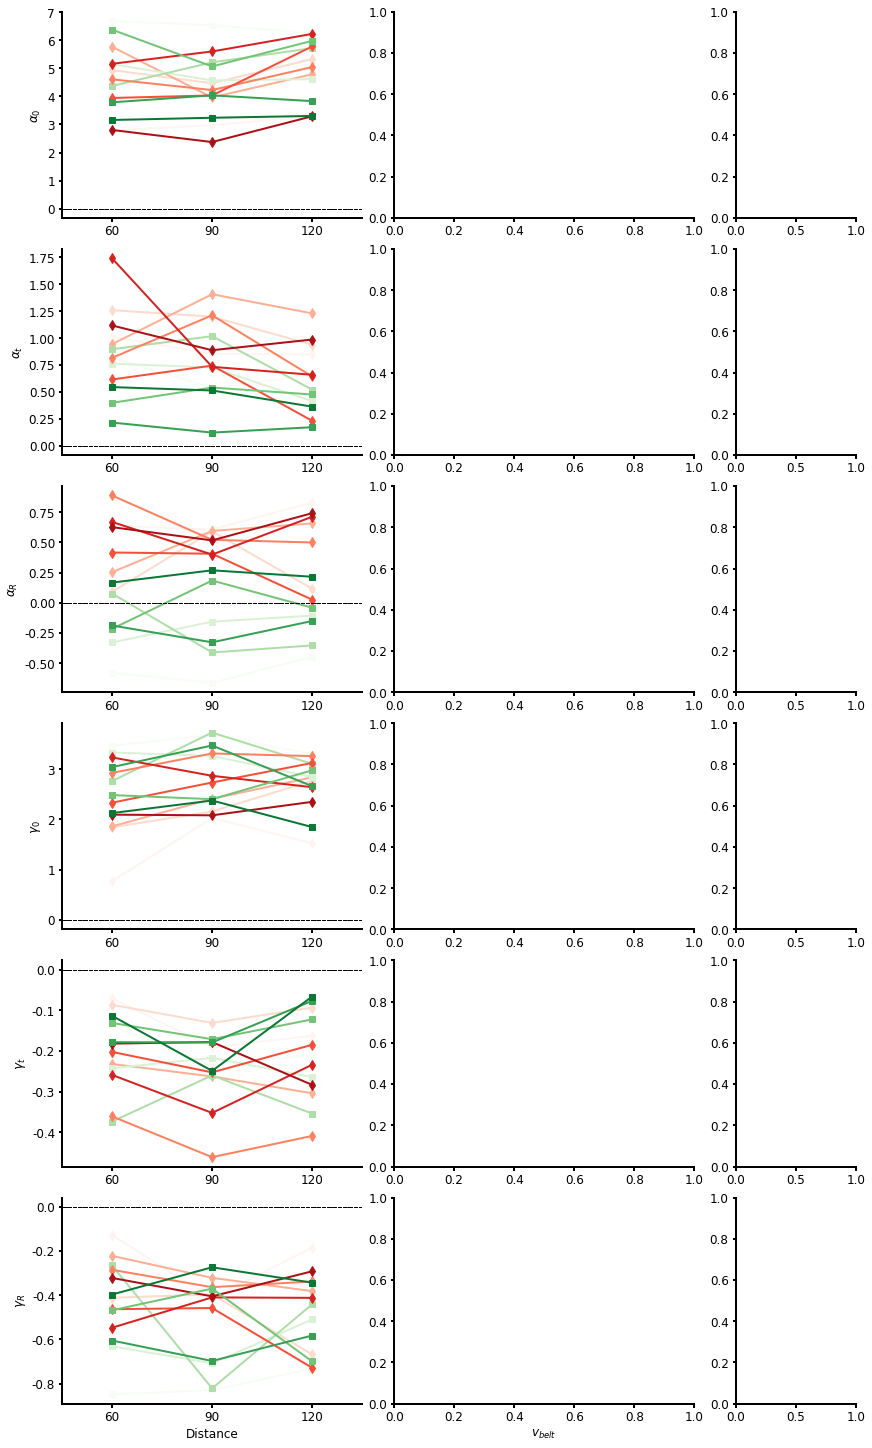

In [11]:

fig, axs = plt.subplots(6, 3, figsize=(12, 20), gridspec_kw={'width_ratios': [5, 5, 2]})
ylabels = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for animal in animalList:
    alpha[animal] = {"60": 0, "90": 0, "120": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0}
    # lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    
# for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], 
#                         [data60IDLE, data90IDLE, data120IDLE, data20IDLE, data10IDLE, data2IDLE, datarev10IDLE, datarev20IDLE]):

for cond, data in zip(["60", "90", "120", ], 
                        [data60IDLE, data90IDLE, data120IDLE]):
    print(cond)
    _ = minimize(oh_wow, [1.5, 0, .75, 0.2, 0, -0.07, 0, 0, -0.2], args=(data))


    for animal in animalList: 
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]) = beurk[animal]

   
   
vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):

        x, y = np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]]
        axs[i, 0].plot(x, y, color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], markersize=6.5, lw=2)
        # gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        # axs[i, 0].plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color=rat_markers[animal][0], lw=2 if p_value < .05 else .5)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        # axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')


In [12]:

Zalpha = {animal: {key: (alpha[animal][key] - np.mean([alpha[animal][key] for animal in intact]))/np.std([alpha[animal][key] for animal in intact]) for key in alpha[animal]} for animal in animalList}
Zalpha_t = {animal: {key: (alpha_t[animal][key] - np.mean([alpha_t[animal][key] for animal in intact]))/np.std([alpha_t[animal][key] for animal in intact]) for key in alpha_t[animal]} for animal in animalList}
Zalpha_R = {animal: {key: (alpha_R[animal][key] - np.mean([alpha_R[animal][key] for animal in intact]))/np.std([alpha_R[animal][key] for animal in intact]) for key in alpha_R[animal]} for animal in animalList}
Zgamma = {animal: {key: (gamma[animal][key] - np.mean([gamma[animal][key] for animal in intact]))/np.std([gamma[animal][key] for animal in intact]) for key in gamma[animal]} for animal in animalList}
Zgamma_t = {animal: {key: (gamma_t[animal][key] - np.mean([gamma_t[animal][key] for animal in intact]))/np.std([gamma_t[animal][key] for animal in intact]) for key in gamma_t[animal]} for animal in animalList}
Zgamma_R = {animal: {key: (gamma_R[animal][key] - np.mean([gamma_R[animal][key] for animal in intact]))/np.std([gamma_R[animal][key] for animal in intact]) for key in gamma_R[animal]} for animal in animalList}

traitsIDLE = {animal: [] for animal in animalList}
ZvarsIDLE = [Zalpha, Zalpha_t, Zalpha_R, Zgamma, Zgamma_t, Zgamma_R]
for j, zvar in enumerate(ZvarsIDLE):
    xmin, xmax = 0, 0
    ymax = 0
    allIntact = []
    allLesion = []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120"]]
        xx = np.linspace(stats.norm.ppf(0.02, loc=np.mean(zscores), scale=np.std(zscores)), stats.norm.ppf(.98, loc=np.mean(zscores), scale=np.std(zscores)), 100)
        if min(xx) < xmin:
            xmin = min(xx)
        if max(xx) > xmax:
            xmax = max(xx)
        pdf = stats.norm.pdf(xx, np.mean(zscores), np.std(zscores))
        if max(pdf) > ymax:
            ymax = max(pdf)
        traitsIDLE[animal].append(np.mean(zscores))
        if brainstatus[animal] == "normal":
            axs[j, 1].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allIntact.extend(zscores)
        else:
            axs[j, 2].plot(pdf, xx, color=rat_markers[animal][0], linestyle=lines[brainstatus[animal]])
            allLesion.extend(zscores)


$\alpha_0$ corr: 0.01, p: 0.9657
$\alpha_t$ corr: -0.89, p: 0.0000
$\alpha_R$ corr: -0.75, p: 0.0033
$\gamma_0$ corr: 0.38, p: 0.2014
$\gamma_t$ corr: 0.25, p: 0.4020
$\gamma_R$ corr: -0.55, p: 0.0496


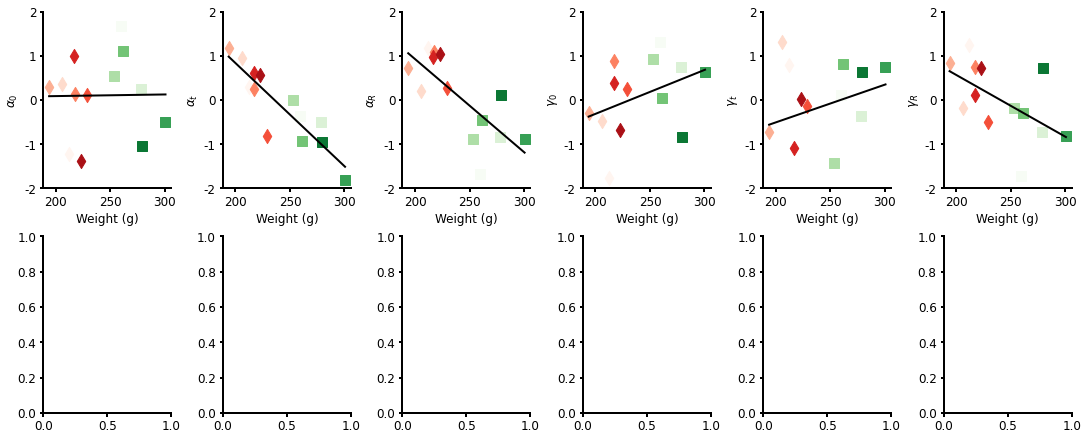

In [14]:
weights = {'RatF00': 212.02, 'RatF01': 205.85, 'RatF02': 193.75,
            'RatM00': 259.37, 'RatM01': 278.12, 'RatM02': 253.19,
            # 'RatF20': 220.10, 'RatF21': 215.53, 'RatF22': 215.0,
            # 'RatM20': 254.68, 'RatM21': 307.29, 'RatM22': 330.53,
            'RatF30': 217.32, 'RatF31': 228.95, 'RatF32': 216.80, 'RatF33': 222.77,
            'RatM30': 261.38, 'RatM31': 300.55, 'RatM32': 279.23, 
            # 'RatF30L': 217.32, 'RatF31L': 228.95, 'RatF32L': 216.80, 'RatF33L': 222.77,
            # 'RatM30L': 261.38, 'RatM31L': 300.55, 'RatM32L': 279.23
            'RatF40': 196.85, 'RatF41': 199.24, 'RatF42': 206.02,
            'RatM40': 238.70, 'RatM41': 238.19, 'RatM42': 242.87, 'RatM43': 262.23}

fig, ax = plt.subplots(2, 6, figsize=(15, 6))
for j, zvar in enumerate(ZvarsIDLE):
    _x, _y = [], []
    for animal in animalList:
        zscores = [zvar[animal][cond] for cond in ["60", "90", "120",]]
        y = np.mean(zscores)
        x = weights[animal]

        ax[0, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
        ax[0, j].set_xlabel("Weight (g)")
        ax[0, j].set_ylabel(ylabelsIDLE[j])
        ax[0, j].set_ylim(-2, 2)

        _x.append(x)
        _y.append(y)

    pearson = stats.pearsonr(_x, _y)
    print(ylabelsIDLE[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
    ax[0, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

# for j, zvar in enumerate(ZvarsRUN):
#     _x, _y = [], []
#     for animal in intact:
#         zscores = [zvar[animal][cond] for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]]
#         y = np.mean(zscores)
#         x = weights[animal]

#         ax[1, j].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
#         ax[1, j].set_xlabel("Weight (g)")
#         ax[1, j].set_ylabel(ylabelsRUN[j])
#         ax[1, j].set_ylim(-2, 2)

#         _x.append(x)
#         _y.append(y)

#     pearson = stats.pearsonr(_x, _y)
#     print(ylabelsRUN[j]+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
#     gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
#     ax[1, j].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)

# correlation parameters Sdrops Seffort

60
90
120
20
10
2
rev10
rev20


Text(0, 0.5, 'effort [J]')

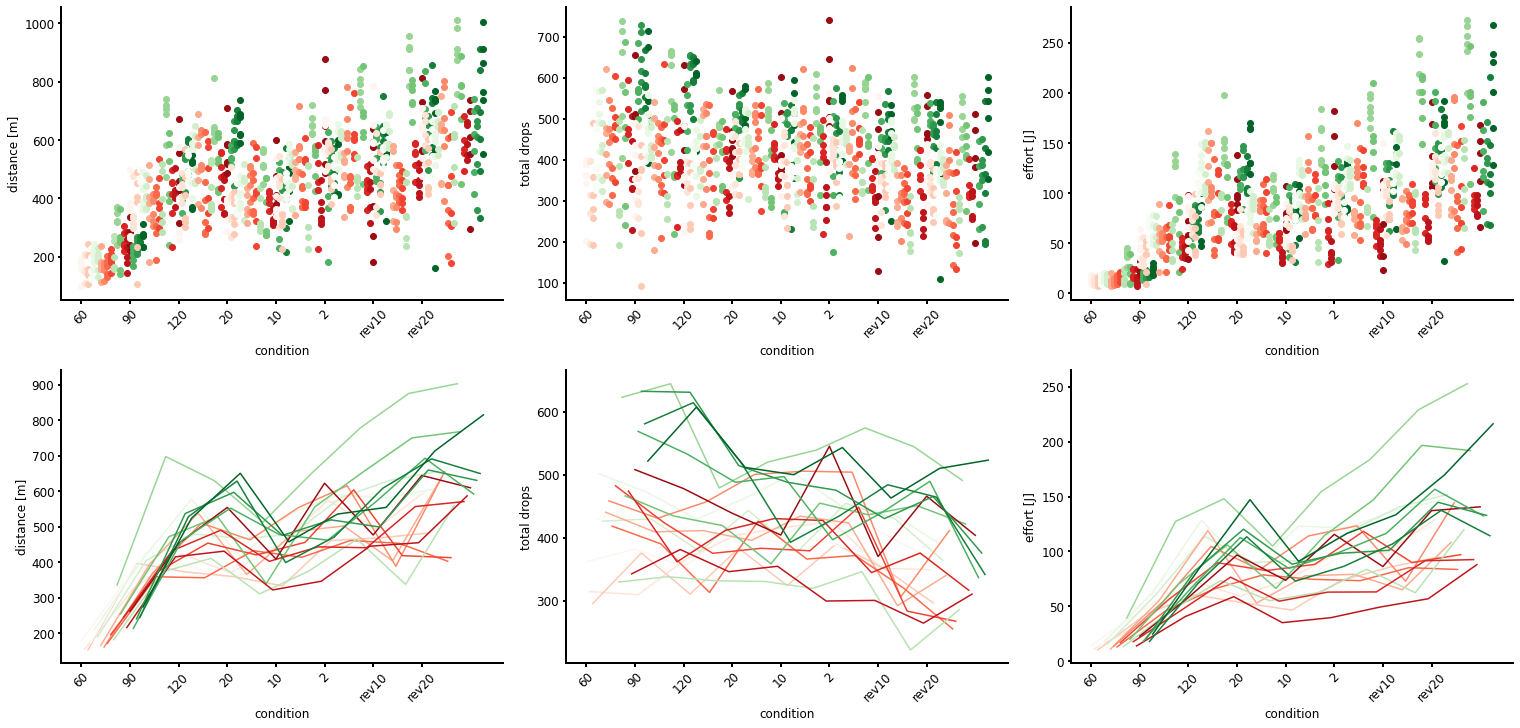

In [139]:
<
# looong ~ 40min, pickled
def get_session_total_distance(animal, session):
    tm_speed = get_from_pickle(root, animal, session, name="params.p")['treadmillSpeed'][0]
    '''get the total distance travelled in a session in meters'''
    pos = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    cameraEdit = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[11])[:90000]
     
    pos, cameraEdit = fix_start_session(pos, cameraEdit)
    pos = fixcamglitch(time, pos, cameraEdit)
    pos = smooth(np.array(pos, dtype=float), 2)

    TM1_pfPOS = [16.1, 97.3]
    TM2_pfPOS = [17.2, 98.1]

    D = abs(np.diff(pos)/100)
    correction = np.zeros(len(D))
    for idx, (pos, dist) in enumerate(zip(pos, D)):
        if TM1_pfPOS[0] < pos < TM1_pfPOS[1]:
            dist -= tm_speed/100 * 0.04
            correction[idx] = dist if dist > 0 else 0

    tot = [0]
    tot.extend(correction)
    totaldist = np.cumsum(tot)
    return totaldist[-1]


from scipy.ndimage import gaussian_filter as smooth
from VIGOR_dataProcessing import fixcamglitch, fix_start_session
def get_session_total_effort(animal, session):
    '''get the total effort expended in a session in Joules'''
    pos = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    cameraEdit = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[11])[:90000]
     
    pos, cameraEdit = fix_start_session(pos, cameraEdit)
    pos = fixcamglitch(time, pos, cameraEdit)
    pos = smooth(np.array(pos, dtype=float), 2)
    w = weights[animal]/1000
    alpha = 1
    beta = 0

    # correct distance for treadmill speed
    tm_speed = get_from_pickle(root, animal, session, name="params.p")['treadmillSpeed'][0]

    TM1_pfPOS = [16.1, 97.3]
    TM2_pfPOS = [17.2, 98.1]

    D = abs(np.diff(pos)/100)
    correction = np.zeros(len(D))
    for idx, (pos, dist) in enumerate(zip(pos, D)):
        if TM1_pfPOS[0] < pos < TM1_pfPOS[1]:
            dist -= tm_speed/100 * 0.04
            correction[idx] = dist if dist > 0 else 0

    instant_effort = ((alpha * w * (correction ** 2)) / np.diff(time)) + beta * w * np.diff(time)
    # instant_effort = ((alpha * w * (abs(np.diff(pos)/100) ** 2)) / np.diff(time)) + beta * w * np.diff(time)
    instant_effort = np.insert(instant_effort, 0, beta * w * 0.04)
    return np.cumsum(instant_effort)[-1]

def get_session_total_drops(sequence):
    totaldrops = 0
    for elem in sequence:
        if sequence[elem][1] == 'run':
            if sequence[elem][2] == 1:
                totaldrops += 1
    return totaldrops


fig, axs = plt.subplots(2, 3, figsize=(21, 10))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
total_dist_by_animal = {c: {a:[] for a in animalList} for c in conds}
total_drops_by_animal = {c: {a:[] for a in animalList} for c in conds}
total_effort_by_animal = {c: {a:[] for a in animalList} for c in conds}

sessionlists = [dist60, dist90, dist120, TM20, TM10, TM2+TMrev2, TMrev10, TMrev20]

for jdx, (sessionList, cond) in enumerate(zip(sessionlists, conds)):
    print(cond)
    for idx, animal in enumerate(animalList):
        for session in matchsession(animal, sessionList):
            if not 'L' in session:
                dist = get_session_total_distance(animal, session)
                drops = get_session_total_drops(sequence[animal, session])
                eff = get_session_total_effort(animal, session)

                axs[0, 0].scatter(jdx+idx/15, dist, color=rat_markers[animal][0])
                axs[0, 1].scatter(jdx+idx/15, drops, color=rat_markers[animal][0])
                axs[0, 2].scatter(jdx+idx/15, eff, color=rat_markers[animal][0])
                total_dist_by_animal[cond][animal].append(dist)
                total_drops_by_animal[cond][animal].append(drops)
                total_effort_by_animal[cond][animal].append(eff)


for idx, animal in enumerate(animalList):
    axs[1, 0].plot([jdx+idx/15 for jdx in range(len(conds))], [np.median(total_dist_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
    axs[1, 1].plot([jdx+idx/15 for jdx in range(len(conds))], [np.median(total_drops_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
    axs[1, 2].plot([jdx+idx/15 for jdx in range(len(conds))], [np.median(total_effort_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])


for ax in axs.flatten():
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(conds, rotation=45)
    ax.set_xlabel('condition')


axs[0, 0].set_ylabel('distance [m]')
axs[0, 1].set_ylabel('total drops')
axs[0, 2].set_ylabel('effort [J]')
axs[1, 0].set_ylabel('distance [m]')
axs[1, 1].set_ylabel('total drops')
axs[1, 2].set_ylabel('effort [J]')

In [141]:
pickle.dump([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], open("picklejar/totaldist_totaldrops_totaleffort.p", "wb"))

# total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))

In [145]:
for i, (total, totalname) in enumerate(zip([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], ['dist', 'drops', 'effort'])):

    _a = [np.median(total["60"][animal]) for animal in animalList]
    _b = [np.median(total["90"][animal]) for animal in animalList]
    _c = [np.median(total["120"][animal]) for animal in animalList]
    _d = [np.median(total["20"][animal]) for animal in animalList]
    _e = [np.median(total["10"][animal]) for animal in animalList]
    _f = [np.median(total["2"][animal]) for animal in animalList]
    _g = [np.median(total["rev10"][animal]) for animal in animalList]
    _h = [np.median(total["rev20"][animal]) for animal in animalList]

    f_test = stats.friedmanchisquare(_a, _b, _c, _d, _e, _f, _g, _h)
    print(f'Effect of {totalname} Friedman={f_test[0]:.3f}, p={f_test[1]:.3f}')

Effect of dist Friedman=103.133, p=0.000
Effect of drops Friedman=38.983, p=0.000
Effect of effort Friedman=119.317, p=0.000


Text(0, 0.5, 'effort [J]')

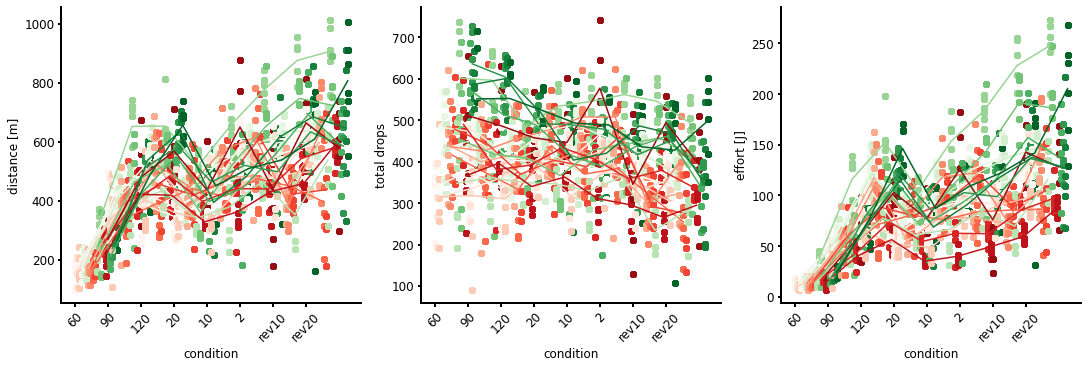

In [146]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


for jdx, (sessionList, cond) in enumerate(zip(sessionlists, conds)):
    for idx, animal in enumerate(animalList):
        for session in matchsession(animal, sessionList):
            if not 'L' in session:
                xxx = [jdx+idx/15 for _ in range(len(total_dist_by_animal[cond][animal]))]
                axs[0].scatter(xxx, total_dist_by_animal[cond][animal], color=rat_markers[animal][0])
                axs[1].scatter(xxx, total_drops_by_animal[cond][animal], color=rat_markers[animal][0])
                axs[2].scatter(xxx, total_effort_by_animal[cond][animal], color=rat_markers[animal][0])




for idx, animal in enumerate(animalList):
    axs[0].plot([jdx+idx/15 for jdx in range(len(conds))], [np.mean(total_dist_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
    axs[1].plot([jdx+idx/15 for jdx in range(len(conds))], [np.mean(total_drops_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])
    axs[2].plot([jdx+idx/15 for jdx in range(len(conds))], [np.mean(total_effort_by_animal[cond][animal]) for cond in conds], color=rat_markers[animal][0])


for ax in axs.flatten():
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(conds, rotation=45)
    ax.set_xlabel('condition')


axs[0].set_ylabel('distance [m]')
axs[1].set_ylabel('total drops')
axs[2].set_ylabel('effort [J]')


In [79]:
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, mu, mu_t, mu_R, sigma, sigma_t, sigma_R]
names = ["alpha", "alpha_t", "alpha_R", "gamma", "gamma_t", "gamma_R", "mu", "mu_t", "mu_R", "sigma", "sigma_t", "sigma_R"]


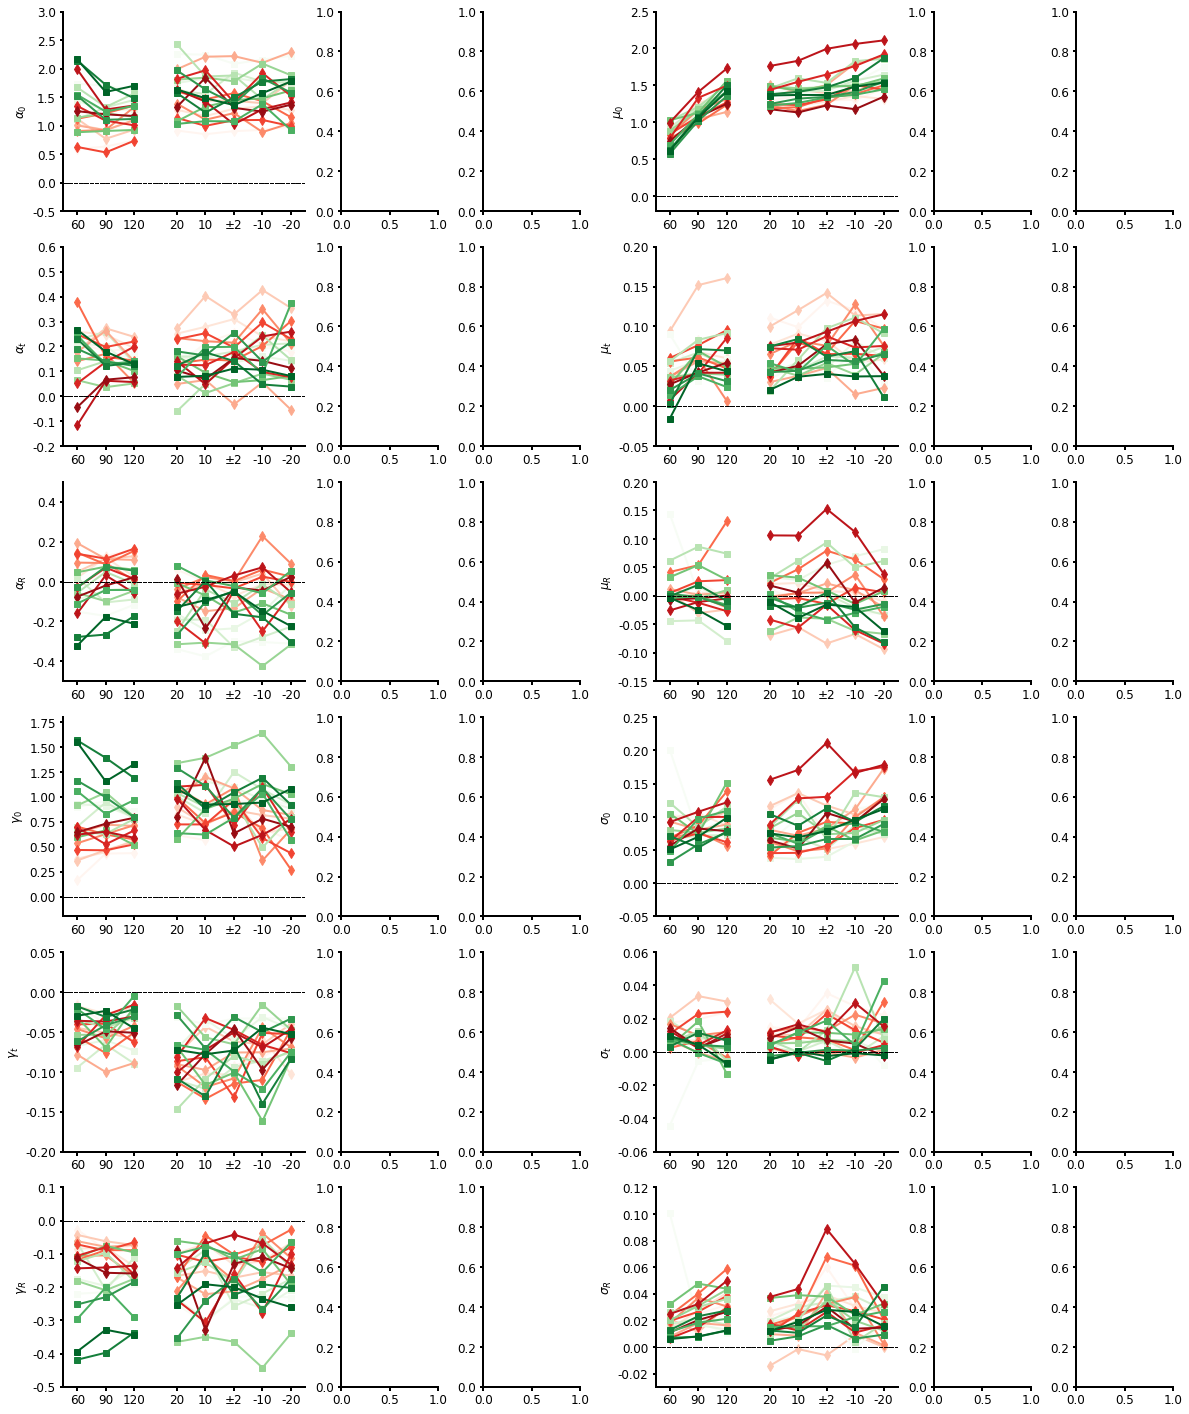

In [147]:
fig, axs = plt.subplots(6, 6, figsize=(42/2.56, 50/2.56), gridspec_kw={'width_ratios': [5, 2, 2, 5, 2, 2]}, constrained_layout=True)
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylimsIDLE = [[-.5, 3], [-.2, .6], [-.5, .5], [-.2, 1.8], [-.2, .05], [-.5, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_R$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_R$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .2], [-.05, .25], [-.06, .06], [-.03, .12], ]

varsIDLE = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
varsRUN = [mu, mu_t, mu_R, sigma, sigma_t, sigma_R, ]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 8)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 3].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].plot([3.5, 4.5, 5.5, 6.5, 7.5], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1],
                        markersize=6.5, lw=2, linestyle=lines[brainstatus[animal]])
        axs[i, 3].set_title(f"")
        axs[i, 3].set_xticks([0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5])
        axs[i, 3].set_xticklabels(["60", "90", "120", "20", "10", "±2", "-10", "-20"])
        axs[i, 3].set_ylabel(ylabel)
        axs[i, 3].set_xlim(-.5, 8)
        axs[i, 3].set_ylim(ylim)
        axs[i, 3].axhline(0, color='black', linestyle='--', linewidth=1)
    

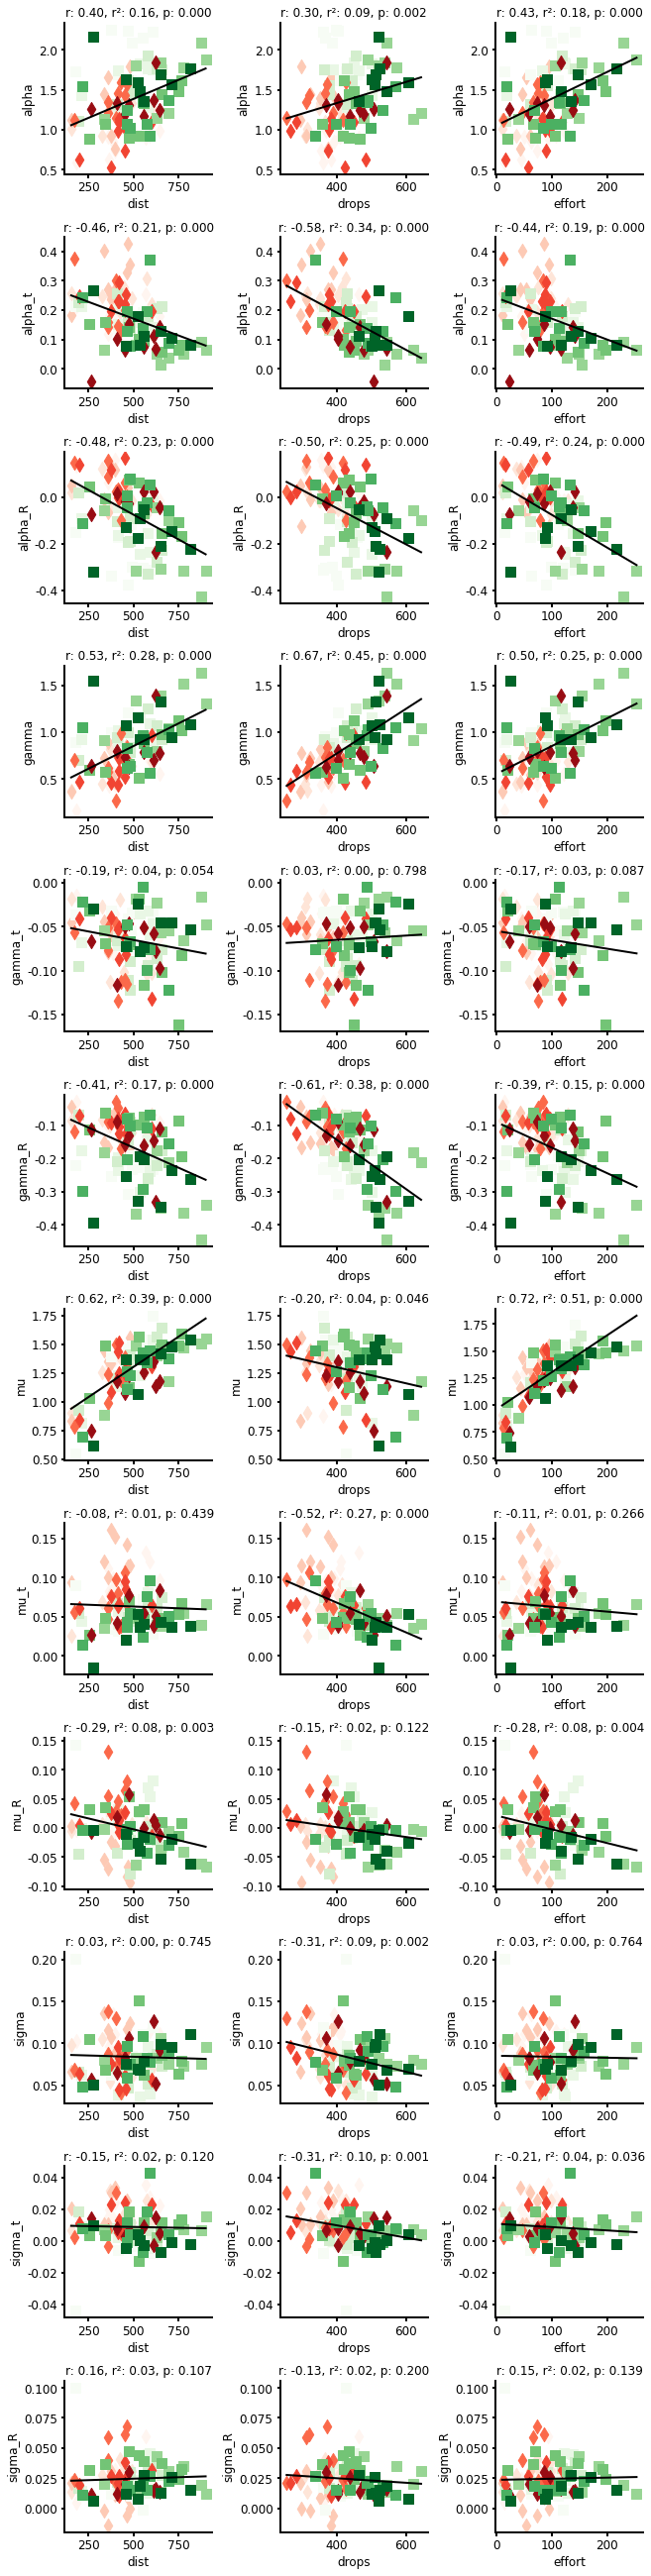

In [161]:
fig, axs = plt.subplots(12, 3, figsize=(9, 36))


for i, (total, totalname) in enumerate(zip([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], ['dist', 'drops', 'effort'])):
    for j, (var, name) in enumerate(zip(vars, names)):
        _x, _y = [], []
        for animal in intact:
            for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]:

                x = np.nanmedian(total[cond][animal])
                y = var[animal][cond]
                axs[j, i].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
                axs[j, i].set_xlabel(totalname)
                axs[j, i].set_ylabel(name)

                _x.append(x)
                _y.append(y)

        # print(_x, _y)
        spearman = stats.spearmanr(_x, _y)
        # print(f'{totalname} & {name} r: {pearson[0]:.2f}, p: {pearson[1]:.4f}')

        gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
        axs[j, i].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)
        axs[j, i].set_title(f'r: {spearman[0]:.2f}, r²: {spearman[0]*spearman[0]:.2f}, p: {spearman[1]:.3f}')
    

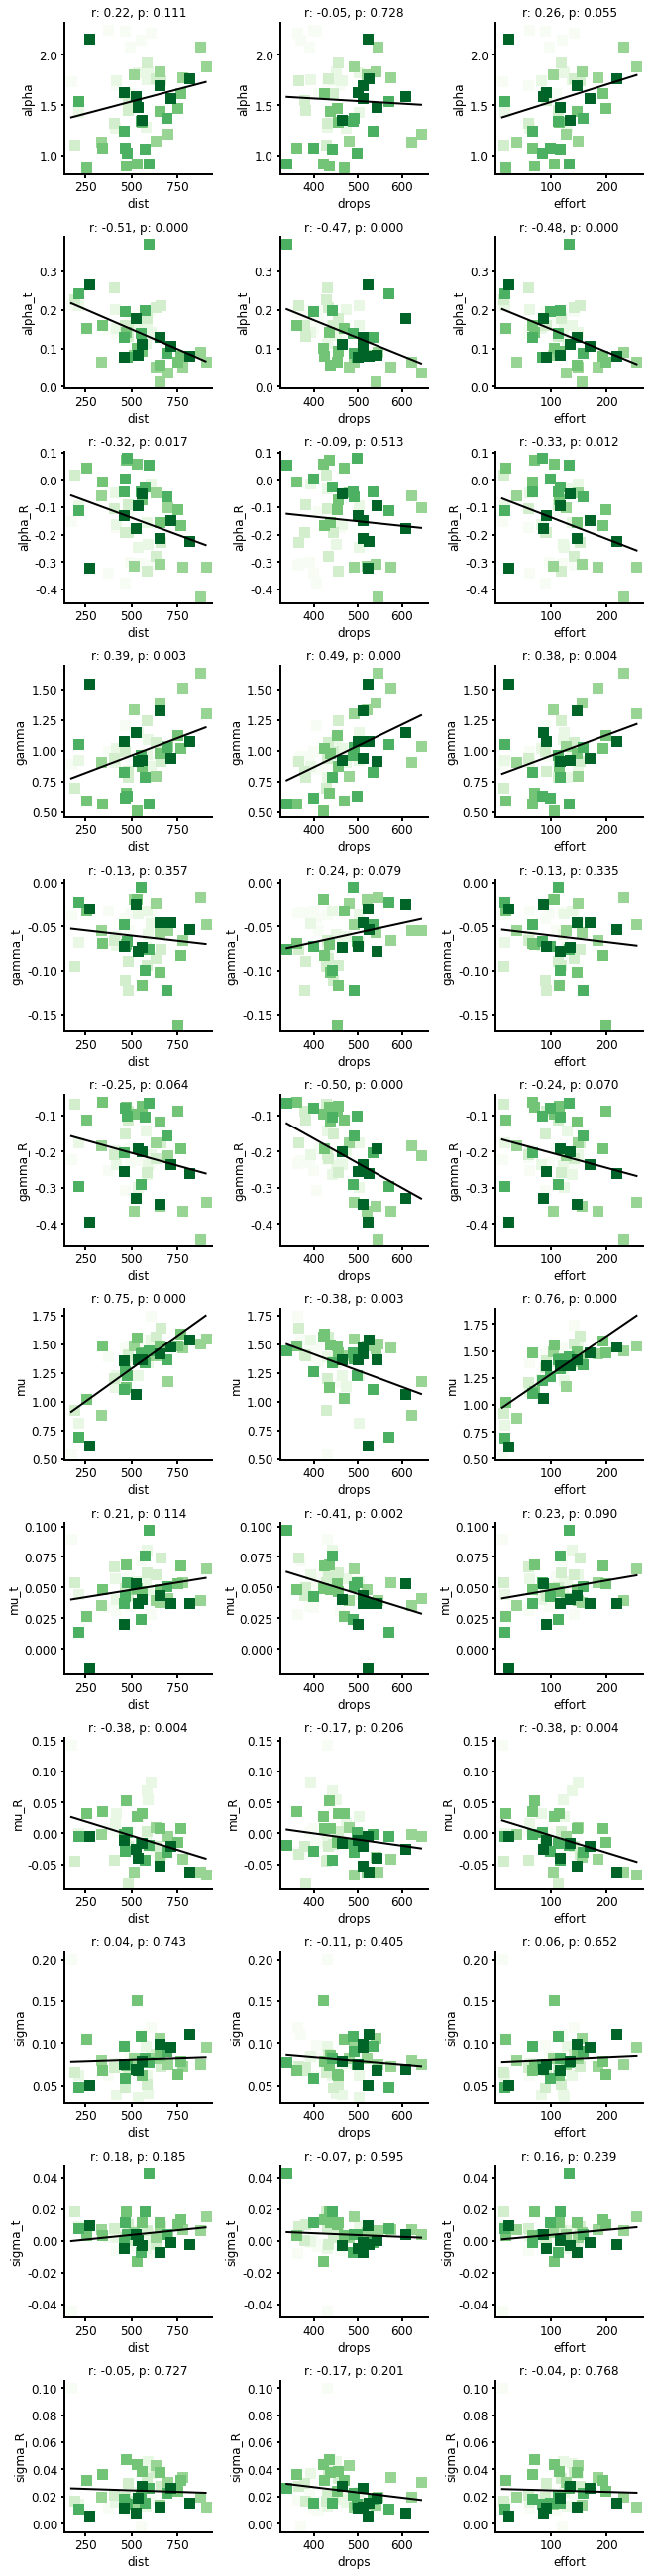

In [158]:
fig, axs = plt.subplots(12, 3, figsize=(9, 36))


for i, (total, totalname) in enumerate(zip([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], ['dist', 'drops', 'effort'])):
    for j, (var, name) in enumerate(zip(vars, names)):
        _x, _y = [], []
        for animal in intact:
            if 'F' in animal:
                continue
            for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]:

                x = np.nanmedian(total[cond][animal])
                y = var[animal][cond]
                axs[j, i].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
                axs[j, i].set_xlabel(totalname)
                axs[j, i].set_ylabel(name)

                _x.append(x)
                _y.append(y)

        # print(_x, _y)
        pearson = stats.pearsonr(_x, _y)
        # print(f'{totalname} & {name} r: {pearson[0]:.2f}, p: {pearson[1]:.4f}')

        gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
        axs[j, i].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)
        axs[j, i].set_title(f'r: {pearson[0]:.2f}, p: {pearson[1]:.3f}')
    

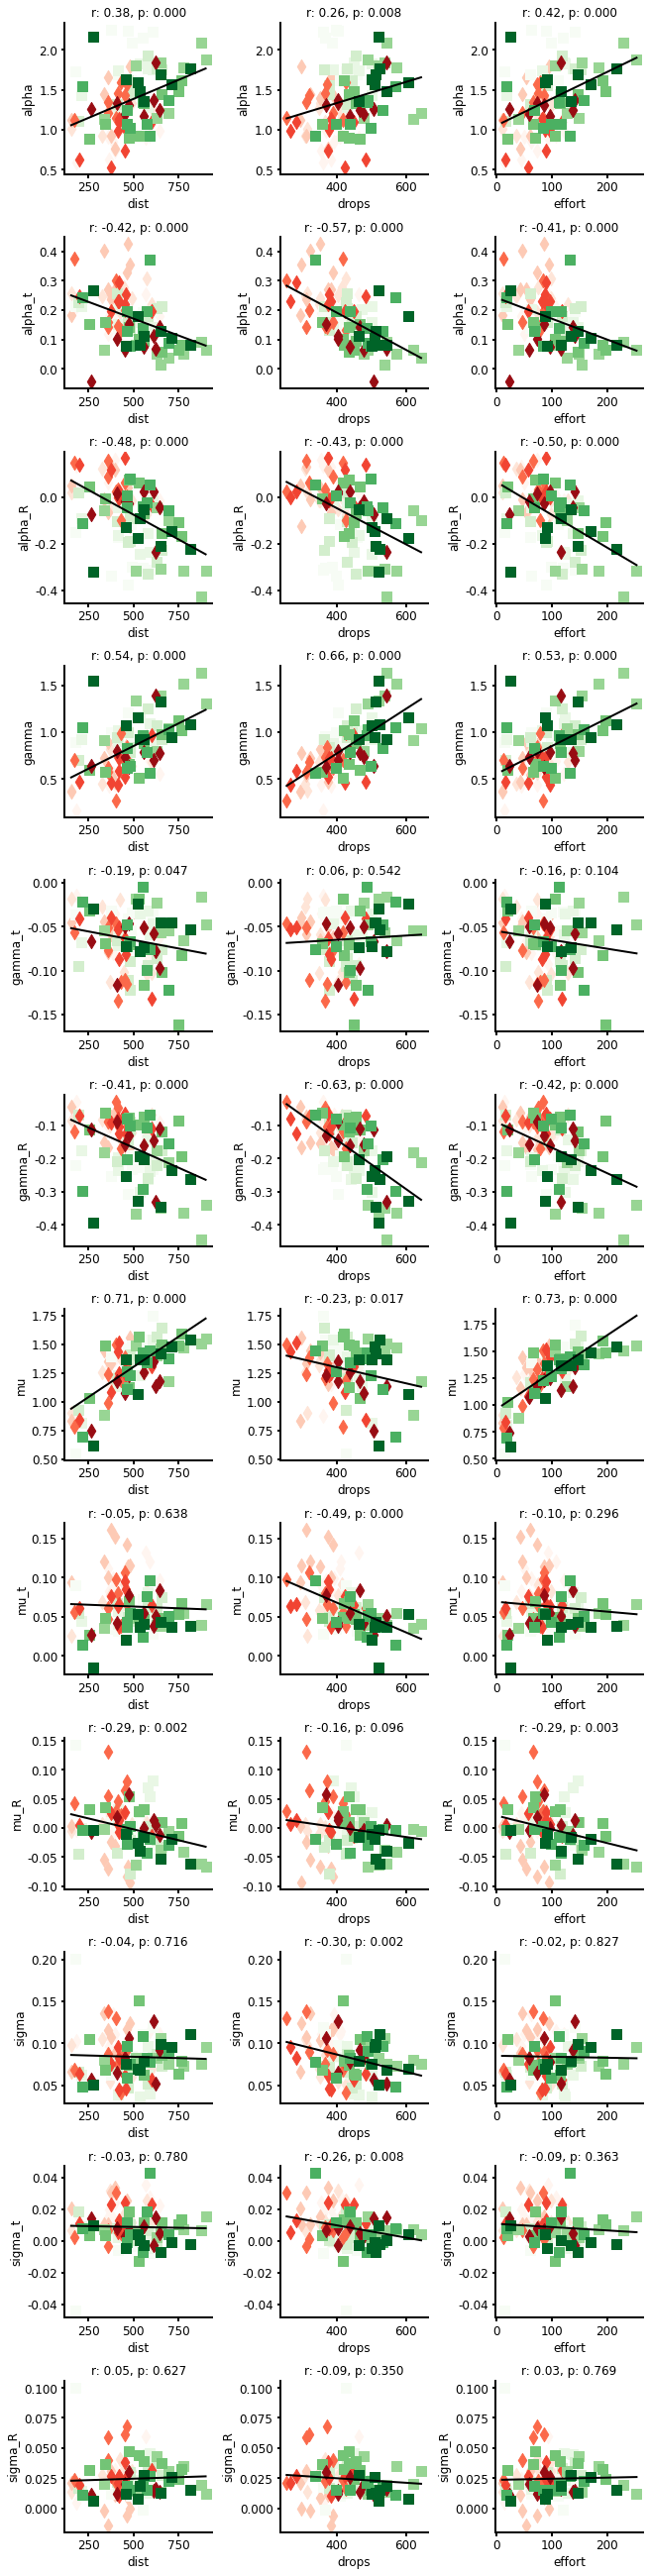

In [156]:
fig, axs = plt.subplots(12, 3, figsize=(9, 36))


for i, (total, totalname) in enumerate(zip([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], ['dist', 'drops', 'effort'])):
    for j, (var, name) in enumerate(zip(vars, names)):
        _x, _y = [], []
        for animal in intact:

            for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]:

                x = np.nanmedian(total[cond][animal])
                y = var[animal][cond]
                axs[j, i].scatter(x, y, color=rat_markers[animal][0], marker=rat_markers[animal][1], s=100)
                axs[j, i].set_xlabel(totalname)
                axs[j, i].set_ylabel(name)

                _x.append(x)
                _y.append(y)

        # print(_x, _y)
        pearson = stats.pearsonr(_x, _y)
        # print(f'{totalname} & {name} r: {pearson[0]:.2f}, p: {pearson[1]:.4f}')

        gradient, intercept, r_value, p_value, std_err = stats.linregress(_x, _y)
        axs[j, i].plot(np.linspace(np.min(_x), np.max(_x), 100), gradient * np.linspace(np.min(_x), np.max(_x), 100) + intercept, color='black', lw=2)
        axs[j, i].set_title(f'r: {pearson[0]:.2f}, p: {pearson[1]:.3f}')
    